
<div style="line-height:2px;border: solid orange">
    <p>
    <p style="color:blue;font-family:arial;text-align:right;font-size:20"> Visión por Computador &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Master en Ciencias de Datos e Ingeniería de Ordenadores   &nbsp;&nbsp;
  <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Rosa Mª. Rodríguez Sánchez   &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> Dpto. Ciencias de la Computación e Inteligencia Artificial. &nbsp;&nbsp;  
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> ETSIIT. Universidad de Granada   &nbsp;&nbsp;
        <p>
</div>

#Transferencia de Conocimiento. Clasificación de imágenes

## Introducción
En esta lección veremos dentro de la clasificación usando aprendizaje profundo como aplicar la **transferencia de conocimiento**. Vamos a entender por transferencia de conocimiento a el proceso de tomar rasgos aprendidos sobre un problema para usarlo en un nuevo problema de características similares.
La transferencia de conocimiento se usa cuando tenemos una base de datos con muy pocos casos para entrenar un modelo completo.
La pasos para  aplicar transferencia de conocimiento podrían ser los siguientes:
* Tomamos capas de un modelo previamente entrenado en otro problema.
* Congerlar las capas, esto quiere decir que no se destruye ninguna información aprendida en estas capas cuando apliquemos el entrenamiento.
* Añadir algunas capas a nuestro modelo relativas  a la parte de clasificación, las capas finales, que se situan detrás de las congeladas. Además de las primeras capas que permite adaptar los datos a la red.
* Entrenar el conjunto de nuevas capas con nuestro conjunto de datos.

Un último paso opcional es lo que se denomina **fine-tuning**. Esto consiste en descongelar el modelo entero, y reentrenar el modelo entero con el nuevo conjunto de datos con una razón de aprendizaje muy baja. Se parte con los rasgos aprendidos por el modelo original.
Vamos a ver todos estos conceptos usando un modelo preentrenado sobre el conjunto de imágenes <a src=http://www.image-net.org/>ImageNet</a> y lo renetrenamos con la base de datos de <a src=https://www.kaggle.com/c/dogs-vs-cats> Kaggle "dogs and cats"</a>.


### Bibliotecas que necesitamos


In [1]:
#!pip install tensorflow


import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

### Congelación de capas
Las capas y modelos tienen tres atributos relativos al peso:
* weights: es la lista de los variables asociadas a los pesos de la capa.
* trainable_weights: es la lista de aquellos pesos que son modificados, via gradiente descendente, para minimizar el error durante el entrenamiento.
* non_trainable_weights: es la lista de aquellos pesos que no son entrenados. Son mosificados por el modelo durante la fase de ir hacia adelante.

Por ejemplo una capa densa tiene 2 pesos entrenables (kernel y sesgo).


In [2]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Crea los pesos

print("weights:", len(layer.weights))
print("weights:", layer.weights)
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 2
weights: [<Variable path=dense/kernel, shape=(4, 3), dtype=float32, value=[[-0.77552783  0.7523054  -0.07102603]
 [-0.5511698  -0.03815717 -0.37827957]
 [-0.00796735  0.66079915 -0.8356115 ]
 [-0.24892539 -0.3941887   0.55195606]]>, <Variable path=dense/bias, shape=(3,), dtype=float32, value=[0. 0. 0.]>]
trainable_weights: 2
non_trainable_weights: 0


En general, todos los pesos son pesos entrenables. La única capa que no tiene pesos entrenables es la capa BatchNormalization. Usa pesos no entrenables para mantener la traza de la media y la varianza de sus entradas durante el entrenamiento. Pero tambien tiene dos pesos entrenables que son parte de la formualación lineal.


In [3]:
#en una capa BatchNormalization tenemos como parámetros
# media varianza beta y gamma. Esto dos últimos son entrenables
#la media y varianza no son enrenables.
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))  # Crea los pesos

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 4
trainable_weights: 2
non_trainable_weights: 2


Las capas y modelos tienen una variable booleana entrenable. Su valor puede ser modificado. Por ejemplo poniendo layer.trainable a False los pesos de la capa pasan de ser entrenables a no entrenables.  Este proceso se denomina **congelar la capa**. En este estado la capa durante el entrenamiento no será modificada.



In [4]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creamos los pesos
layer.trainable = False  # Congelamos la capa

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 2
trainable_weights: 0
non_trainable_weights: 2


Veamos un ejemplo

In [5]:
# Creamos una arquitectura con dos capas
layer1 = tf.keras.layers.Dense(3, activation="relu",input_shape=(3,))
layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
model = tf.keras.Sequential([ layer1, layer2])

# Congelamos la primera capa
layer1.trainable = False

# Hacemos una copia de los pesos para comprobar si se ha modificado
initial_layer1_weights_values = layer1.get_weights()

# Entrenamos el modelo
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Comprobamos que los pesos de la primera capa no se han modificado
final_layer1_weights_values = layer1.get_weights()
# Salta un excepción si los dos objetos nos son iguales
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1058


### Atributo trainable.
En el siguiente ejemplo se muestra que capas son entrenables o no. Cuando se pone un modelo o capa a no entrenable todas las subcapas se vuelven no entrenables.


In [6]:
inner_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(3,)),
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(3, activation="relu"),
    ]
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(3,)),
        inner_model,
        tf.keras.layers.Dense(3, activation="sigmoid"),
    ]
)

model.trainable = False  # Congelamos
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 3)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 36 (144.00 B)

## Ejemplo Transferencia de Conocimiento

A modo de ejemplo vamos a aplicar una CNN usando transferencia de conocimiento a la base de datos Kaggle cats and dogs.
Vamos a usar la arquitectura Xception previamente entrenada sobre ImageNet.

En primer lugar vamos a cargar nuestra base de datos.

In [7]:
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
#No usamos toda la base de datos solamente el 60%
(train_ds, validation_ds, test_ds),metadata = tfds.load(
    "cats_vs_dogs",
    #  10% para validación 10% para test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    with_info=True,
    as_supervised=True  # cargamos las etiquetas
)

print("Imágenes para el entrenamiento: %d" % tf.data.experimental.cardinality(train_ds))
print("Imágenes para la validación: %d" % tf.data.experimental.cardinality(validation_ds))
print("Imagenes para el test: %d" % tf.data.experimental.cardinality(test_ds))
num_classes = metadata.features['label'].num_classes
print(num_classes)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.B31E4T_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Imágenes para el entrenamiento: 9305
Imágenes para la validación: 2326
Imagenes para el test: 2326
2


In [8]:
print(tfds.__version__)

4.9.7


Veamos algunas de las imágenes

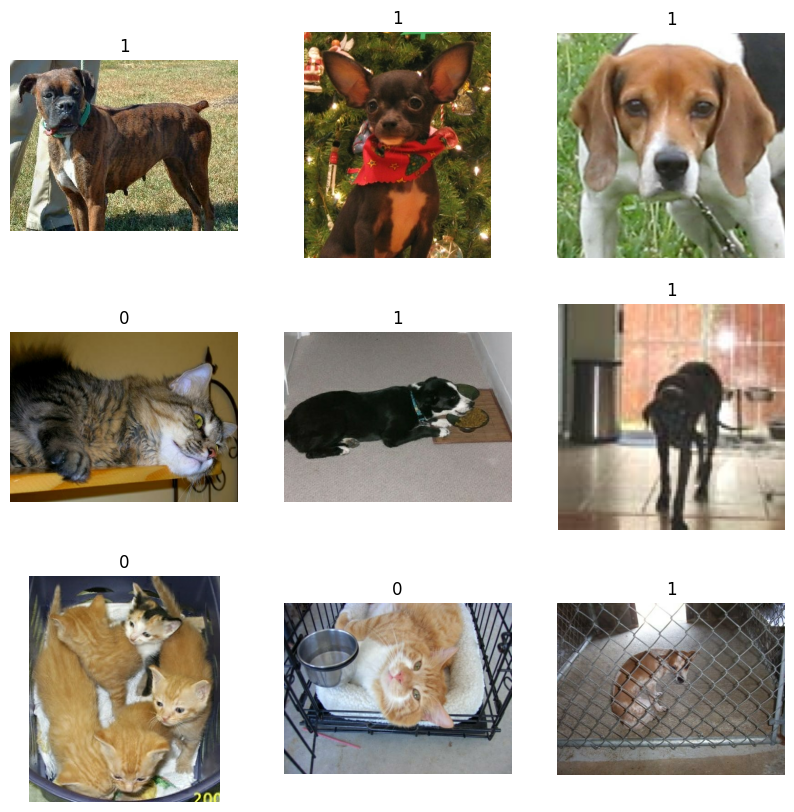

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
#Label=1 dot label=0 cat

#### Homogenizar las imágenes
Las imágenes tienen diferentes tamaños. Las imágenes son de color, 3 canales RGB, en el rango cada uno de ellos 0-255. Antes de pasarlas a nuestra CNN debemos realizar los siguientes pasos:
* Igualar el tamaño de todas las imágenes a 150x150.
* Usar aumentación del conjunto de datos de forma aleatoria
* Normalizamos los valores de los pixeles al rango -1,1

En el siguiente código realizamos los dos primeros pasos:


In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))



batch_size = 32
#la primera vez que se itera sobre la base de datos se pone en cache.
#en las siguientes iteraciones se tomarán los datos de la cache.
#creamos lotes de tamaño batch_size
#prefetch permite preparar los siguientes elementos mientras
#que estan siendo procesaods los actuales elementos.
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)
print(train_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


A continuación vamos a aplicar a las imágenes diferentes  transformaciones geométricas. Este proceso evita el sobre ajuste de la red. Para ello creamos una arquitectura con dos capas una que realiza reflejo horizontal y otra rotación.

In [11]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
    [
        #Reflejo horizontal
        layers.RandomFlip("horizontal"),
        #Rotaciones
        layers.RandomRotation(0.1),
    ]
)
#otras transformaciones posibles puede ser
#RandomCrop layer
#RandomTranslation layer
#RandomZoom layer
#RandomContrast layer
#RandomBrightness layer



Veamos un ejemplo de aplicación de data_augmentation


(32, 150, 150, 3)


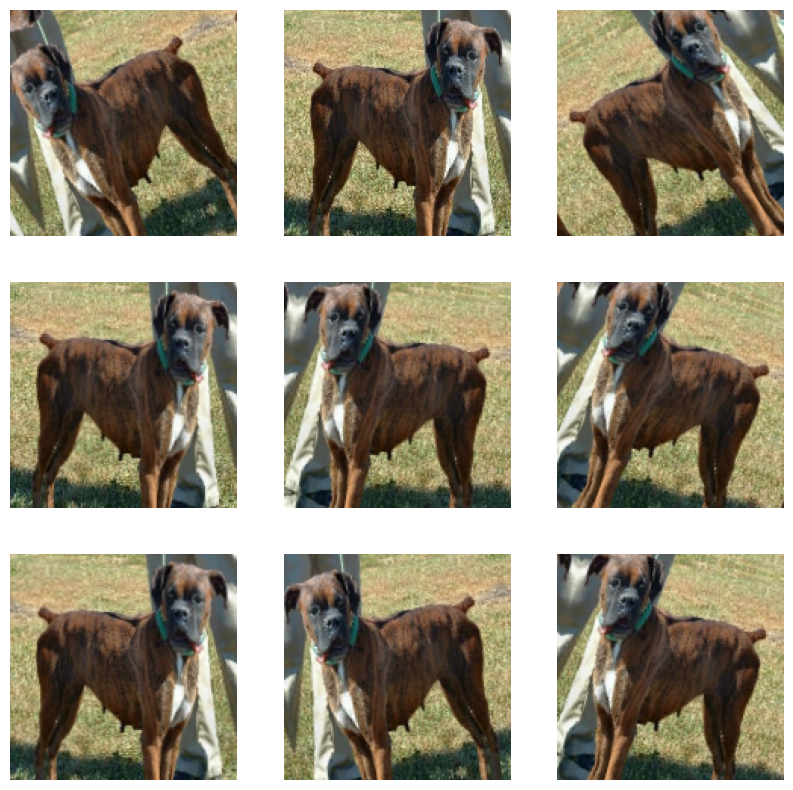

In [12]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    print(images.shape)
    first_image = images[0]

    #plt.imshow(first_image)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        #expand_dims lo que hace es poner como primera dimension el tamaño de lote que es 1 luego 150x150x3
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0), training=True)

        plt.imshow(augmented_image[0].numpy().astype("int32"))

        plt.axis("off")



Antes de definir el modelo vamos a aclarar que hace la capa GlobalMaxPooling2d. Esta capa obtiene el maximo de todos las entradas en la capa.

In [13]:
#EJEMPLO de GlobalMaxPooling
# creamos el modelo
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(1, (3,3), activation='relu',padding="same", input_shape=(8, 8, 1)))
model.add(tf.keras.layers.GlobalMaxPooling2D())
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 1)             │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1)                   │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

### Definimos el modelo

Las características son:
* Vamos a usar Xception como arquitectura base
* Vamos a añadir una capa de normalización para escalar la imagen que están en el rango [0,255] al rango [-1,1]
* Vamos a insertar una capa Dropout antes para la capa de clasificación para evitar sobre ajuste.
* Nos aseguramos poner training=false cuando usamos el modelo base. Asi que el aprendizaje afectara a la parte de clasificación y primera capas


En el código de abajo hay tener en cuenta que GlobalAveragePooling2D submuestrea el conjunto de rasgos en un solo rasgo.

In [14]:
#Los modelos que contiene keras los puedes consultar en https://keras.io/api/applications/
base_model = keras.applications.Xception(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#La primera capa  no se incluye
)
#si quieres ver Xception
#base_model.summary()

# Congelamos
base_model.trainable = False

# Añadirmos la primera capa
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplicamos el aumento de datos.
#Normalizamos al rango [-1,1]
#usando outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2

# Scale inputs to [-1, +1]
norm_layer = keras.layers.Normalization(mean=mean,variance=var)

x = norm_layer(x)



x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizamos
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Entrenamos la primera capa


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    #cuando solamente tenemos dos etiquetas. COn from_logits=true para obtener
    #probabilidades
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    #redondea las probabilidades a 0-1 y estima como coincide y_pred y y_real
    metrics=[keras.metrics.BinaryAccuracy()],
)
#Deberiamos usar más epocas pero por rapidez ponemos 5
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - binary_accuracy: 0.8913 - loss: 0.2318 - val_binary_accuracy: 0.9682 - val_loss: 0.0834
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - binary_accuracy: 0.9458 - loss: 0.1275 - val_binary_accuracy: 0.9690 - val_loss: 0.0796
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - binary_accuracy: 0.9506 - loss: 0.1165 - val_binary_accuracy: 0.9703 - val_loss: 0.0775
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - binary_accuracy: 0.9560 - loss: 0.1103 - val_binary_accuracy: 0.9703 - val_loss: 0.0753
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - binary_accuracy: 0.9535 - loss: 0.1066 - val_binary_accuracy: 0.9746 - val_loss: 0.0718


Ahora evaluamos el modelo sobre el conjunto test. Pero previamente lo vamos a almacenar en disco para poder recuperarlo en el futuro y no tener que entrenarlo de nuevo.

73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - binary_accuracy: 0.9737 - loss: 0.0658
Test loss: 0.0735856220126152
Test accuracy: 0.9724849462509155
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step
Clase predicha [0]


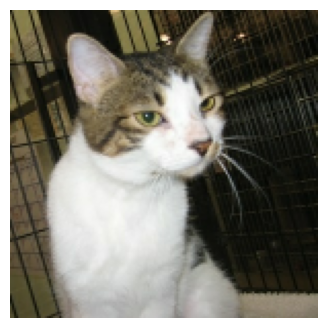

In [16]:
#almacenamos
#model.save('mimodelo_xception.h5')
#como se recuperaria
#model = keras.models.load_model('mimodelo_xception.h5')

#Ahora lo vamos a evaluar
score = model.evaluate(test_ds)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

#predecir las etiquetas

y_prob = model.predict(test_ds)
y_classes = (y_prob > 0.5)*1

print('Clase predicha',y_classes[0])
for images, label in test_ds.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    plt.imshow(first_image.numpy().astype("int32"))
    plt.axis("off")




## Fine-Tuning
Podemos ahora descongelar todo el modelo y reentrenar el modelo entero con una razón de aprendizaje muy baja.
Este paso puede obtener mejoras en la agudeza, pero tenemos que tener en mente que tambien podriamos obtener un sobreajuste. Así que hay que mirar todo con cuidado.
Este paso se debe hacer tras haber entrenado el modelo con las capas congeladas para alcanzar la convergencia de las capas no congeladas. Si mezclaramos el entrenamiento con capas ya entrenadas y capas que se inicializan aleatoriamente puede  causar que el gradiente debe acometer grandes pasos durante el entrenamiento destruyendo los rasgos de las capas ya entrenadas.
En esta etapa también es crítico usar razones de aprendizaje muy pequeñas ya que el conjunto de datos sobre los que se están aplicando es menor que sobre el conjunto de datos para el que fue entrenado el modelo base. Además si se aplica grandes modificaciones de los pesos, que se obtiene a una razón de aprendizaje mayor, se puede obtener sobre ajuste. Por lo tanto nuestro objetivo es readaptar un poco los pesos a la nueva base de datos.
Así se implementa fine-tuning al modelo entero.



In [17]:
# Descongelamos el modelo base
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Una razón de aprendizaje muy pequeña
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Entrenamos el modelo entero
model.fit(train_ds, epochs=5,  validation_data=validation_ds)

#almacenamos
#model.save('mimodelo_xception_entero.h5')
#como se recuperaria
#model = keras.models.load_model('mimodelo_xception_entero.h5')

#Ahora lo vamos a evaluar
score = model.evaluate(test_ds)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 131s 347ms/step - binary_accuracy: 0.8624 - loss: 0.3202 - val_binary_accuracy: 0.9587 - val_loss: 0.1101
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 138s 342ms/step - binary_accuracy: 0.9304 - loss: 0.1740 - val_binary_accuracy: 0.9678 - val_loss: 0.0918
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 100s 343ms/step - binary_accuracy: 0.9482 - loss: 0.1317 - val_binary_accuracy: 0.9678 - val_loss: 0.0859
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 101s 347ms/step - binary_accuracy: 0.9592 - loss: 0.1149 - val_binary_accuracy: 0.9708 - val_loss: 0.0756
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 100s 344ms/step - binary_accuracy: 0.9666 - loss: 0.0896 - val_binary_accuracy: 0.9721 - val_loss: 0.0706
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - binary_accuracy: 0.9686 - loss: 0.0801
Test loss: 0.08589150756597519
Test accuracy: 0.9664660096168518


## Ejercicio
<ol>
    <li> Aplicar sobre la base de datos "dogs and cats" el proceso aprendido usando como modelo base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).
    
</ol>

Analizar los resultados obtenidos mostrando tablas, gráficas y conclusiones sobre la agudeza en resultados y eficiencia computacional.




        


Entrenando VGG16...
Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - binary_accuracy: 0.6364 - loss: 0.6071 - val_binary_accuracy: 0.8899 - val_loss: 0.3215
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - binary_accuracy: 0.8326 - loss: 0.3687 - val_binary_accuracy: 0.9123 - val_loss: 0.2570
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - binary_accuracy: 0.8582 - loss: 0.3193 - val_binary_accuracy: 0.9183 - val_loss: 0.2302
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - binary_accuracy: 0.8590 - loss: 0.2983 - val_binary_accuracy: 0.9243 - val_loss: 0.2133
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - binary_accuracy: 0.8687 - loss: 0.2868 - val_binary_accuracy: 0.9261 - val_loss: 0.2074
Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 91s 285ms/step - binary_accuracy: 0.9165 - loss: 0.1852 - val_binary_accuracy: 0.9686 - val_loss: 0.0861
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 80s 275ms/step - binary_accuracy: 0.9601 - loss: 0.0924 - val_binary_accuracy: 0

<ipython-input-2-2d56e0580a97>:66: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = models[model_name](


Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - binary_accuracy: 0.8851 - loss: 0.2546 - val_binary_accuracy: 0.9665 - val_loss: 0.0937
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - binary_accuracy: 0.9482 - loss: 0.1292 - val_binary_accuracy: 0.9686 - val_loss: 0.0825
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - binary_accuracy: 0.9540 - loss: 0.1152 - val_binary_accuracy: 0.9703 - val_loss: 0.0791
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - binary_accuracy: 0.9533 - loss: 0.1194 - val_binary_accuracy: 0.9742 - val_loss: 0.0731
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - binary_accuracy: 0.9576 - loss: 0.1112 - val_binary_accuracy: 0.9764 - val_loss: 0.0682
Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - binary_accuracy: 0.8630 - loss: 0.3459 - val_binary_accuracy: 0.9665 - val_loss: 0.0969
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - binary_accuracy: 0.9318 - loss: 0.1636 - val_binary_accuracy: 0.9708 - val_loss: 0.07

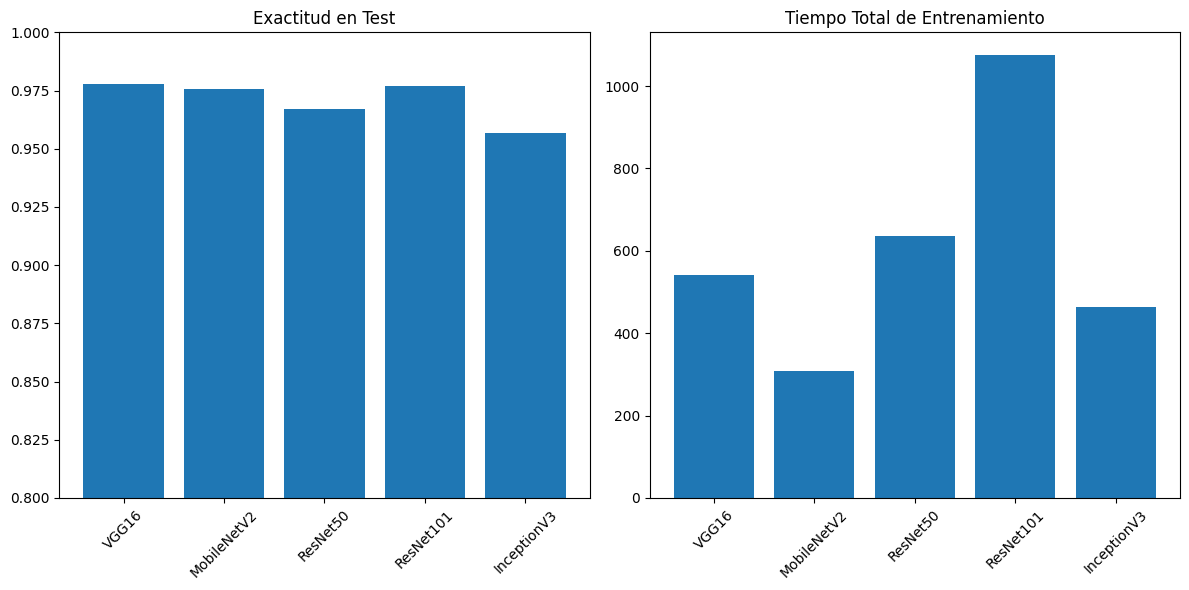

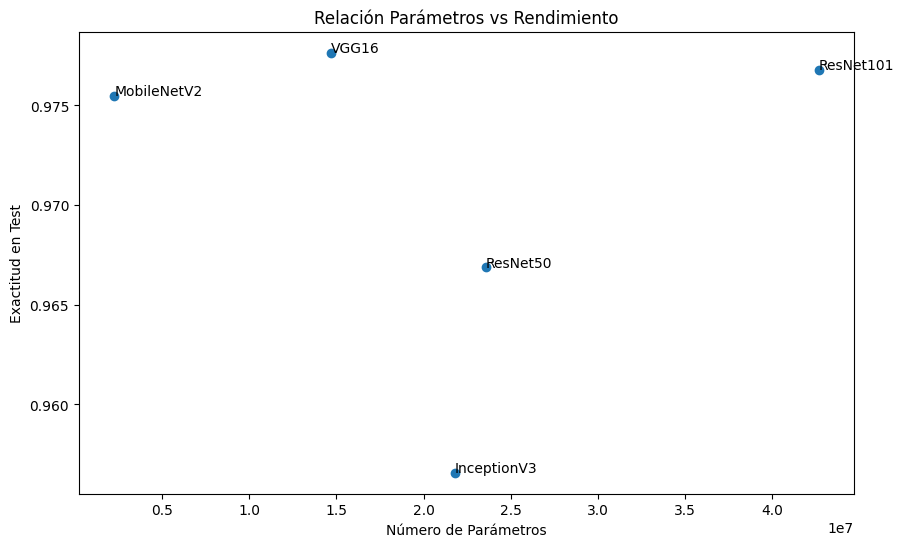

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Cargar dataset
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    with_info=True,
    as_supervised=True
)

# Preprocesamiento
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Aumento de datos
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Normalización
mean = np.array([127.5] * 3)
var = mean ** 2
norm_layer = layers.Normalization(mean=mean, variance=var)

# Modelos a evaluar
models = {
    'VGG16': keras.applications.VGG16,
    'MobileNetV2': keras.applications.MobileNetV2,
    'ResNet50': keras.applications.ResNet50,
    'ResNet101': keras.applications.ResNet101,
    'InceptionV3': keras.applications.InceptionV3,
}

# Resultados
results = []

class TimeCallback(keras.callbacks.Callback):
    def __init__(self):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

for model_name in models:
    print(f"\nEntrenando {model_name}...")

    # Cargar modelo base
    base_model = models[model_name](
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )
    base_model.trainable = False

    # Construir modelo
    inputs = keras.Input(shape=(150, 150, 3))
    x = data_augmentation(inputs)
    x = norm_layer(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Compilar
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()]
    )

    # Entrenamiento inicial
    time_cb = TimeCallback()
    history = model.fit(
        train_ds,
        epochs=5,
        validation_data=validation_ds,
        callbacks=[time_cb]
    )

    # Fine-tuning
    base_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()]
    )

    ft_time_cb = TimeCallback()
    history_ft = model.fit(
        train_ds,
        epochs=5,
        validation_data=validation_ds,
        callbacks=[ft_time_cb]
    )

    # Evaluación
    test_loss, test_acc = model.evaluate(test_ds)

    # Guardar resultados
    results.append({
        'Modelo': model_name,
        'Exactitud Train': history.history['binary_accuracy'][-1],
        'Exactitud Val': history_ft.history['val_binary_accuracy'][-1],
        'Exactitud Test': test_acc,
        'Tiempo Train': sum(time_cb.times),
        'Tiempo Total': sum(time_cb.times) + sum(ft_time_cb.times),
        'Parámetros': model.count_params()
    })

    del model
    del base_model

# Resultados en DataFrame
df_results = pd.DataFrame(results)
print("\nResultados Finales:")
print(df_results)

# Gráficos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_results['Modelo'], df_results['Exactitud Test'])
plt.title('Exactitud en Test')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(df_results['Modelo'], df_results['Tiempo Total'])
plt.title('Tiempo Total de Entrenamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de parámetros vs exactitud
plt.figure(figsize=(10, 6))
plt.scatter(df_results['Parámetros'], df_results['Exactitud Test'])
for i, row in df_results.iterrows():
    plt.annotate(row['Modelo'], (row['Parámetros'], row['Exactitud Test']))
plt.xlabel('Número de Parámetros')
plt.ylabel('Exactitud en Test')
plt.title('Relación Parámetros vs Rendimiento')
plt.show()

# Conclusión
- La precisión en el conjunto de prueba es un indicador clave del rendimiento del modelo. Los resultados muestran que todos los modelos lograron una precisión superior al 95%, lo que indica que son altamente efectivos para la tarea de clasificación binaria de perros y gatos. 
- La eficiencia computacional se evaluó en términos del tiempo de entrenamiento y el número de parámetros de cada modelo. Aquí se observaron diferencias significativas:
    - MobileNetV2 fue el modelo más eficiente, con un tiempo total de entrenamiento de 308.82 segundos y solo 2.26 millones de parámetros. Esto lo convierte en la mejor opción para aplicaciones donde el tiempo y los recursos computacionales son limitados.
    - VGG16 y ResNet50 tuvieron tiempos de entrenamiento similares (540.99 segundos y 636.05 segundos, respectivamente), pero VGG16 logró una mayor precisión con menos parámetros (14.72 millones frente a 23.59 millones de ResNet50).
    - ResNet101 fue el modelo más lento, con un tiempo de entrenamiento de 1076.54 segundos y 42.66 millones de parámetros. Aunque su precisión fue alta, su eficiencia es cuestionable para tareas simples como esta.
    - InceptionV3 tuvo un tiempo de entrenamiento intermedio (463.43 segundos) y un número de parámetros similar a ResNet50 (21.80 millones), pero su precisión fue la más baja.
- El gráfico de dispersión que relaciona el número de parámetros con la precisión en el conjunto de prueba revela que no existe una correlación directa entre la complejidad del modelo y su rendimiento. 
- Para aplicaciones prácticas, MobileNetV2 es la mejor opción debido a su equilibrio entre precisión y eficiencia. El resto de modelos no han mejorado suficiente en relación al tamaño que tienen en comparación con MobileNetV2.